# Understanding Simple Recurrent Neural Networks In Keras
From https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/ 
With changes by Jan Mandel
2021-12-26: small changes for clarity
2022-06-16: added same by functional interface

This tutorial is designed for anyone looking for an understanding of how recurrent neural networks (RNN) work and how to use them via the Keras deep learning library. While all the methods required for solving problems and building applications are provided by the Keras library, it is also important to gain an insight on how everything works. In this article, the computations taking place in the RNN model are shown step by step. Next, a complete end to end system for time series prediction is developed.

After completing this tutorial, you will know:

* The structure of RNN
* How RNN computes the output when given an input
* How to prepare data for a SimpleRNN in Keras
* How to train a SimpleRNN model

Let’s get started.

## Tutorial Overview

This tutorial is divided into two parts; they are:

1. The structure of the RNN
  1. Different weights and biases associated with different layers of the RNN.
  2. How computations are performed to compute the output when given an input.
2. A complete application for time series prediction.

## Prerequisites

It is assumed that you have a basic understanding of RNNs before you start implementing them. An [Introduction To Recurrent Neural Networks And The Math That Powers Them](https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them) gives you a quick overview of RNNs.

Let’s now get right down to the implementation part.

## Import section

In [19]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import tensorflow as tf

## Keras SimpleRNN

The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

In [20]:
api_type = 2   # 1 = sequential, 2 = functional

In [21]:
def create_RNN_sequential(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [22]:
def create_RNN_functional(hidden_units, dense_units, input_shape, activation):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation[0])(inputs)
    outputs = tf.keras.layers.Dense(dense_units, activation=activation[1])(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [23]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    if api_type==1:
      print('using sequential api')
      return create_RNN_sequential(hidden_units, dense_units, input_shape, activation)
    if api_type==2:
      print('using functional api')
      return create_RNN_functional(hidden_units, dense_units, input_shape, activation)
    print('api_type must be 1 or 2, got ',api_type)
    raise(ValueError)

demo_model = create_RNN(hidden_units=2, dense_units=1, input_shape=(3,1), 
                        activation=['linear', 'linear'])

using functional api


The object demo_model is returned with 2 hidden units created via a the SimpleRNN layer and 1 dense unit created via the Dense layer. The input_shape is set at 3×1 and a linear activation function is used in both layers for simplicity. Just to recall the linear activation function f(x)=x makes no change in the input.

In [24]:
print(dir(demo_model))
# help(demo_model)
help(demo_model.get_weights)

['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_assert_compile_was_called', '_assert_weights_created', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_base_model_initialized', '_build_input_shape', '_call_accepts_kwargs', '_call_arg_was_passed', '_call_fn_arg_defaults', '_call_fn_arg_positions', '_call_fn_args', '_call_full_argspec', '_callable_losses', '_cast_single_input', '_check_call_args', '_checkpoint_dependencies', '_clear_losses', '_cluster_co

Look at the model following https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ :

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None


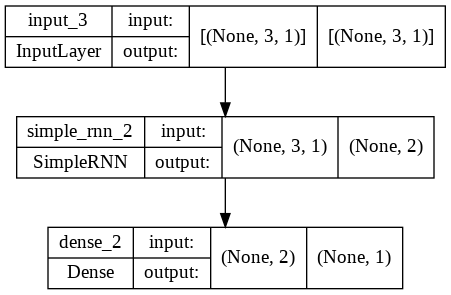

In [25]:
print(demo_model.summary())
from keras.utils.vis_utils import plot_model
plot_model(demo_model, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=True)

If we have m
 hidden units (
m
=
2
 in the above case), then:
* Input: 
x
∈
R
* Hidden unit: 
h
∈
R<sup>m</sup>
* Weights for input units: 
w<sub>x</sub>
∈
 R<sup>m</sup>
* Weights for hidden units: 
w<sub>h</sub>
∈
R<sup>m x m</sup>
* Bias for hidden units: 
b<sub>h</sub>
∈
R
<sup>m</sup>
*Weight for the dense layer: 
w<sub>y</sub>
∈
R
<sup>m</sup>
*Bias for the dense layer: 
b<sub>y</sub>
∈
R

Let’s look at the above weights. The weights are generated randomly so they will be different every time. The important thing is to learn what the structure of each object being used looks like and how it interacts with others to produce the final output. The get_weights() method of the model object returns a list of arrays, which consists of the weights and the bias of each layer, in the order of the layers. The first layer's input takes two entries, the (external) input values and the values of the hidden variables from the previous step.

In [26]:
w = demo_model.get_weights()
#print(len(w),' weight arrays:',w)
wname=('wx','wh','bh','wy','by','wz','bz')
for i in range(len(w)):
  print(i,':',wname[i],'shape=',w[i].shape)

wx = w[0]
wh = w[1]
bh = w[2]
wy = w[3]
by = w[4]

0 : wx shape= (1, 2)
1 : wh shape= (2, 2)
2 : bh shape= (2,)
3 : wy shape= (2, 1)
4 : by shape= (1,)


In [27]:
# help(SimpleRNN)

Now let’s do a simple experiment to see how the layers from a SimpleRNN and Dense layer produce an output. Keep this figure in view.
<img src="https://machinelearningmastery.com/wp-content/uploads/2021/09/rnnCode1.png">

We’ll input x for three time steps and let the network generate an output. The values of the hidden units at time steps 1, 2 and 3 will be computed. 
h<sub>0</sub>
 is initialized to the zero vector. The output 
o<sub>3</sub>
 is computed from 
h<sub>3</sub>
 and 
w<sub>3</sub>
. An activation function is linear, f(x)=x, so the update of $h(k)$ and the output $o(k)$ are given by

\begin{align*}
h\left(  0\right)  = &\left[
\begin{array}
[c]{c}%
0\\
0
\end{array}
\right]  \\
h\left(  k+1\right)  =&x\left(  k\right)  \left[
\begin{array}
[c]{c}%
w_{x,0}\\
w_{x,1}%
\end{array}
\right]  +\left[  h_{0}(k),h_{1}(k)\right]  \left[
\begin{array}
[c]{cc}%
w_{h,00} & w_{h,01}\\
w_{h,10} & w_{h,11}%
\end{array}
\right]  +\left[
\begin{array}
[c]{c}%
b_{h,0}\\
b_{h,1}%
\end{array}
\right]  \\
o(k+1)=& \left[  h_{0}(k+1),h_{1}(k+1)\right]  \left[
\begin{array}
[c]{c}%
w_{y,0}\\
w_{y,1}%
\end{array}
\right] 
\end{align*}


We compute this for $k=1,2,3$ and compare with the output of the model:

In [28]:
x = np.array([1, 2, 3])
# Reshape the input to the required sample_size x time_steps x features 
x_input = np.reshape(x,(1, 3, 1))
y_pred_model = demo_model.predict(x_input)


m = 2
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + np.dot(h0,wh) + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
o3 = np.dot(h3, wy) + by

print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3)

print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

h1 =  [[ 0.26658928 -0.22793353]] h2 =  [[ 0.21754729 -0.608839  ]] h3 =  [[ 0.15476518 -0.63926661]]
Prediction from network  [[-0.837604]]
Prediction from our computation  [[-0.83760395]]


The predictions came out the same! This confirms that we know what the network is doing.

## Step 1, 2: Reading Data and Splitting Into Train And Test

The following function reads the train and test data from a given URL and splits it into a given percentage of train and test data. It returns single dimensional arrays for train and test data after scaling the data between 0 and 1 using MinMaxScaler from scikit-learn.

In [29]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = read_csv(sunspots_url, usecols=[1], engine='python')
train_data, test_data, data = get_train_test(np.array(df.values.astype('float32')))

Let's print the data shape so that we know what we got.

In [30]:
data.shape

(2820,)

## Step 3: Reshaping Data For Keras

The next step is to prepare the data for Keras model training. The input array should be shaped as: **(total_samples, x time_steps, x features)**.
There are many ways of preparing time series data for training. We’ll create input rows with non-overlapping time steps. An example is shown in the figure below. Here time_steps denotes the number of previous time steps to use for predicting the next value of the time series data. We have for time_steps = 2, features = 1, and the first 6 terms are split total_samples=3 samples: 0, 10 predict the next term 20, then 20, 30 predict the next term 40, etc.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/09/rnnCode2.png">

The following function get_XY() takes a one dimensional array as input and converts it to the required input X and target Y arrays.

In [31]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

For illustration, on the simple example above it returns the expected result: 

In [32]:
dat = np.linspace(0.,70.,8).reshape(-1,1)
print("dat shape=",dat.shape)
X, Y = get_XY(dat, 2)
print("X shape=",X.shape)
print("Y shape=",Y.shape)
#print('dat=',dat)
print('X=',X)
print('Y=',Y)


dat shape= (8, 1)
X shape= (3, 2, 1)
Y shape= (3, 1)
X= [[[ 0.]
  [10.]]

 [[20.]
  [30.]]

 [[40.]
  [50.]]]
Y= [[20.]
 [40.]
 [60.]]


Now use it for the sunspot data.  We’ll use 12 time_steps for the sunspots dataset as the sunspots generally have a cycle of 12 months. You can experiment with other values of time_steps.

In [33]:
time_steps = 24
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)
print("trainX shape=",trainX.shape)
print("trainY shape=",trainY.shape)
print("testX shape=",testX.shape)
print("testY shape=",testY.shape)

trainX shape= (93, 24, 1)
trainY shape= (93,)
testX shape= (23, 24, 1)
testY shape= (23,)


## Step 4: Create RNN Model And Train

In [34]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

using functional api
Epoch 1/20
93/93 - 2s - loss: 0.0512 - 2s/epoch - 18ms/step
Epoch 2/20
93/93 - 1s - loss: 0.0248 - 537ms/epoch - 6ms/step
Epoch 3/20
93/93 - 0s - loss: 0.0191 - 476ms/epoch - 5ms/step
Epoch 4/20
93/93 - 0s - loss: 0.0172 - 484ms/epoch - 5ms/step
Epoch 5/20
93/93 - 1s - loss: 0.0156 - 518ms/epoch - 6ms/step
Epoch 6/20
93/93 - 0s - loss: 0.0144 - 400ms/epoch - 4ms/step
Epoch 7/20
93/93 - 0s - loss: 0.0131 - 308ms/epoch - 3ms/step
Epoch 8/20
93/93 - 0s - loss: 0.0121 - 352ms/epoch - 4ms/step
Epoch 9/20
93/93 - 0s - loss: 0.0110 - 298ms/epoch - 3ms/step
Epoch 10/20
93/93 - 0s - loss: 0.0098 - 310ms/epoch - 3ms/step
Epoch 11/20
93/93 - 0s - loss: 0.0088 - 309ms/epoch - 3ms/step
Epoch 12/20
93/93 - 0s - loss: 0.0077 - 325ms/epoch - 3ms/step
Epoch 13/20
93/93 - 0s - loss: 0.0070 - 306ms/epoch - 3ms/step
Epoch 14/20
93/93 - 0s - loss: 0.0068 - 317ms/epoch - 3ms/step
Epoch 15/20
93/93 - 0s - loss: 0.0066 - 340ms/epoch - 4ms/step
Epoch 16/20
93/93 - 0s - loss: 0.0065 - 336ms

## Step 5: Compute And Print The Root Mean Square Error

In [35]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.076 RMSE
Test RMSE: 0.120 RMSE


## Step 6: View The result

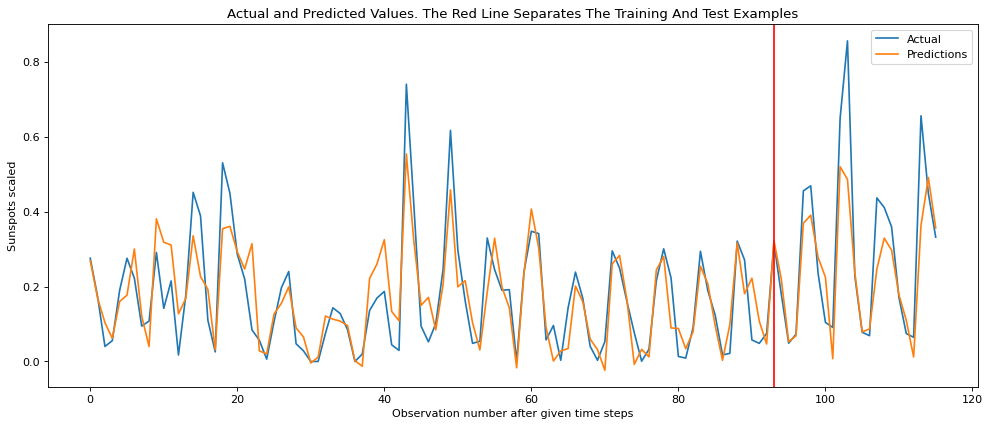

In [36]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)